#Detección de cancer de piel con DeepLeaning CNN

##Montando el dataset

In [ ]:
!pip install -q kaggle
!pip install -q kaggle-cli

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

{"username":"juanjozr1","key":"4262d424cf6d65dd7a8d7af729497dbf"}

In [ ]:
!kaggle datasets download nodoubttome/skin-cancer9-classesisic

Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other
100% 785M/786M [00:31<00:00, 25.2MB/s]
100% 786M/786M [00:31<00:00, 26.3MB/s]


In [ ]:
!unzip skin-cancer9-classesisic

##Librerias que usaremos

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

##Creando el conjunto de datos

In [ ]:
data_dir = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


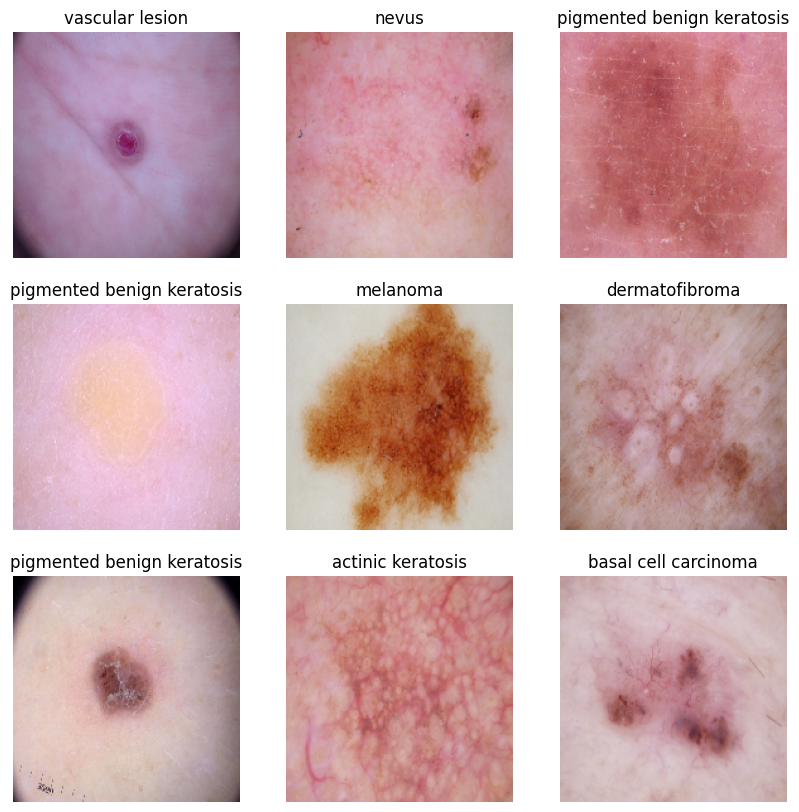

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0076793004 0.7911764


##Creando Modelo
Aplicando 3 bloques de convolución

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

##Entrenando Modelo

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1881 - loss: 2.3077 - val_accuracy: 0.3445 - val_loss: 1.7974
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3422 - loss: 1.8094 - val_accuracy: 0.4161 - val_loss: 1.6285
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4219 - loss: 1.5715 - val_accuracy: 0.4966 - val_loss: 1.5227
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4951 - loss: 1.4092 - val_accuracy: 0.5168 - val_loss: 1.4377
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5259 - loss: 1.2911 - val_accuracy: 0.5369 - val_loss: 1.4121
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5583 - loss: 1.2229 - val_accuracy: 0.5235 - val_loss: 1.4683
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6013 - loss: 1.1365 - val_accuracy: 0.5615 - val_loss: 1.3559
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6435 - loss: 1.0165 - val_accuracy: 0.5749 - val_loss:

##Visualización de los datos

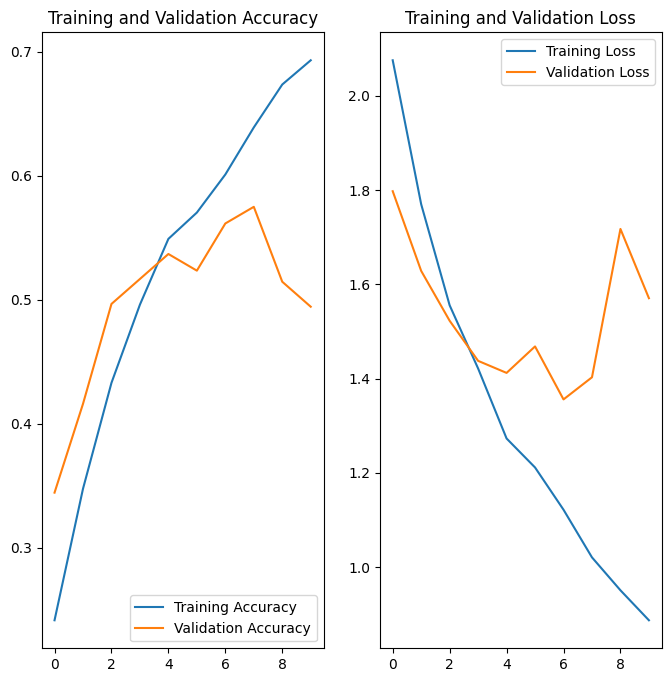

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Aumento de datos
El sobreajuste generalmente ocurre cuando hay una pequeña cantidad de ejemplos de entrenamiento. El aumento de datos adopta el enfoque de generar datos de entrenamiento adicionales a partir de sus ejemplos existentes al aumentarlos mediante transformaciones aleatorias que producen imágenes de aspecto creíble. Esto ayuda a exponer el modelo a más aspectos de los datos y a generalizar mejor.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

##Visualizacion con el aumento de datos

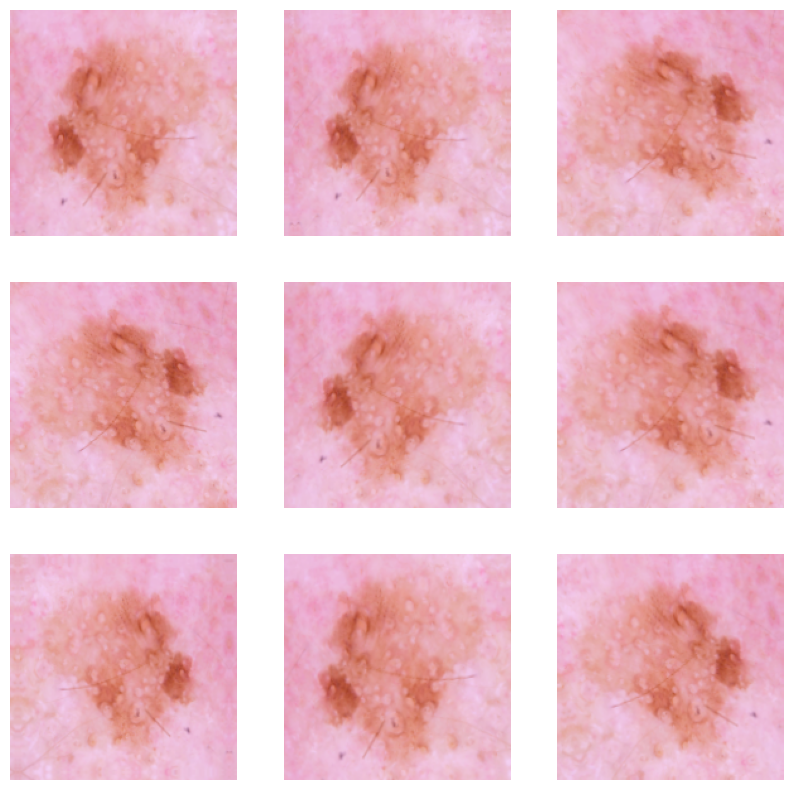

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##Abandonar
Abandonar
Otra técnica para reducir el sobreajuste es introducir la regularización de abandonos en la red.

Cuando aplica abandono a una capa, descarta aleatoriamente (estableciendo la activación en cero) una cantidad de unidades de salida de la capa durante el proceso de entrenamiento. Dropout toma un número fraccionario como su valor de entrada, en forma de 0.1, 0.2, 0.4, etc. Esto significa eliminar aleatoriamente el 10%, 20% o 40% de las unidades de salida de la capa aplicada.

Vamos a crear una nueva red neuronal con tf.keras.layers.Dropout antes de entrenarla usando las imágenes aumentadas:

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

##Volvemos a entrenar el modelo

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.2109 - loss: 2.1659 - val_accuracy: 0.3624 - val_loss: 1.8335
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.3431 - loss: 1.8038 - val_accuracy: 0.4183 - val_loss: 1.6834
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4605 - loss: 1.5053 - val_accuracy: 0.4720 - val_loss: 1.5291
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4731 - loss: 1.4731 - val_accuracy: 0.4899 - val_loss: 1.4777
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5180 - loss: 1.3316 - val_accuracy: 0.5078 - val_loss: 1.3924
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5400 - loss: 1.2720 - val_accuracy: 0.5369 - val_loss: 1.3128
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5366 - loss: 1.2723 - val_accuracy: 0.5347 - val_loss: 1.3286
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5479 - loss: 1.2396 - val_accuracy: 0.5123 - val_loss:

##Visualización

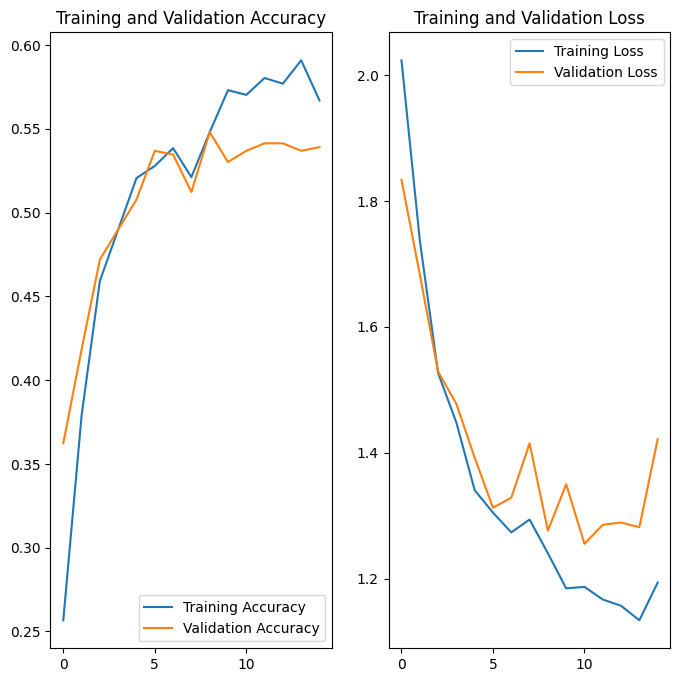

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Evaluar el modelo con un nuevo dato

  Usaremos una imagen totalmente la cual no fue usada en el entrenamiento para probar la capacidad de reconocimiento de nuestro modelo.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to melanoma with a 99.26 percent confidence.


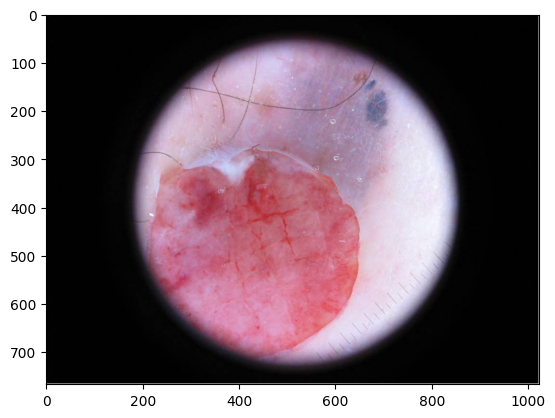

In [ ]:

path = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000004.jpg"
plt.imshow(plt.imread(path))
img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)